In [3]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import ta

from startegy002 import Strategy002
from strategy_bacd import StrategyBacd

ModuleNotFoundError: No module named 'strategies'

In [10]:
SYMBOL = 'ETH'
from_csv = pd.read_csv(f'../../data/{SYMBOL}.csv')
df = from_csv.set_index(pd.DatetimeIndex(from_csv['begins_at'].values))
df = df.rename(columns={"begins_at":"time", "open_price":"open", "close_price":"close", "low_price":"low", "high_price":"high"})
df['average'] = df[['high','low']].mean(axis=1)
df = df.drop(columns=["time"])

In [11]:
#Create a function to signal when to buy and sell an asset
def calculate_when_to_trade(dataframe, strategy):
    sigPriceBuy = []
    sigPriceSell = []
    cycles = []
    bought = False
    for i in range(0,len(dataframe)):
        current_price = dataframe['average'][i]
        if bought == False and strategy.shouldBuy(dataframe, i):
            sigPriceBuy.append(current_price)
            sigPriceSell.append(np.nan)
            bought = i
        elif bought != False and strategy.shouldSell(dataframe, i, bought): 
            sigPriceSell.append(current_price)
            sigPriceBuy.append(np.nan)
            cycles.append(current_price - dataframe['average'][bought])
            # print(f"Profit: {current_price - dataframe['average'][bought]}")
            bought = False
        else: #Handling nan values
            sigPriceBuy.append(np.nan)
            sigPriceSell.append(np.nan)
    return (sigPriceBuy, sigPriceSell, cycles)

def plot(df, sigPriceBuy, sigPriceSell):
    plt.figure(figsize=(20,4.5))
    plt.xticks(rotation=45)
    plt.plot( df['average'],  label='price', linewidth=1)
    plt.scatter(df.index, sigPriceBuy, color = 'green', label='Buy Signal', marker = '^', alpha = 1)
    plt.scatter(df.index, sigPriceSell, color = 'red', label='Sell Signal', marker = 'v', alpha = 1)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

generating indicators
strategy advised sell point
Profit: -0.7296539999999823
strategy advised sell point
Profit: 5.0244294999999966
strategy advised sell point
Profit: -2.0
strategy advised sell point
Profit: 10.7448830000003
strategy advised sell point
Profit: 4.967499999999745
strategy advised sell point
Profit: 11.704999999999927
strategy advised sell point
Profit: -20.59308249999981
strategy advised sell point
Profit: 7.692539500000066
strategy advised sell point
Profit: 16.507500000000164
strategy advised sell point
Profit: -6.065000000000055
strategy advised sell point
Profit: -4.345000000000027
strategy advised sell point
Profit: -0.45250000000010004
strategy advised sell point
Profit: 2.3174999999998818
strategy advised sell point
Profit: 3.049999999999727
strategy advised sell point
Profit: 4.070391999999856
strategy advised sell point
Profit: -0.25
strategy advised sell point
Profit: 1.6842329999999492
strategy advised sell point
Profit: 8.790000000000191
strategy advised se

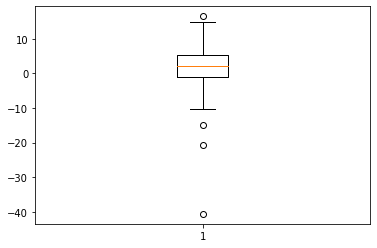

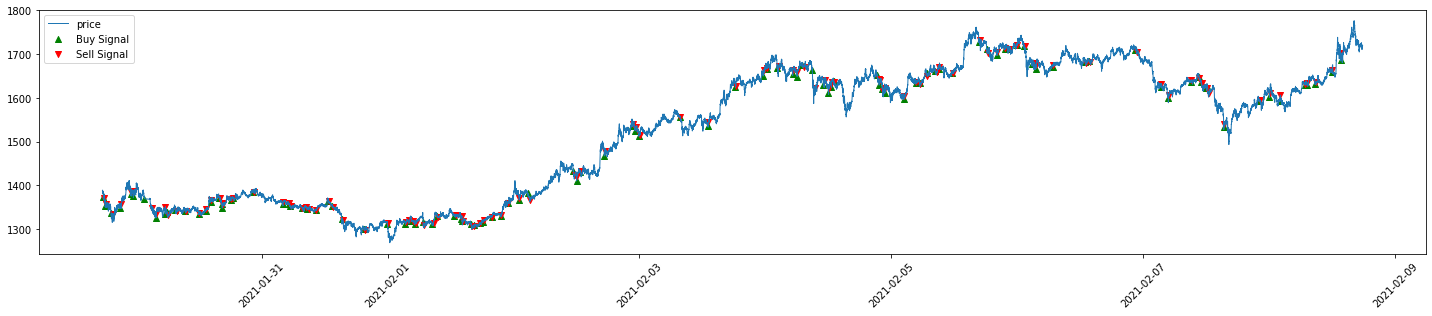

In [12]:
# strat = Strategy002()
strat = StrategyBacd()

df = strat.generateIndicators(df)

sigPriceBuy, sigPriceSell, cycles = calculate_when_to_trade(df, strat)

print("Executed buy and sell strategies:")
print(f"Number of cycles: {len(cycles)}")
print(f"Total: ${sum(cycles):.2f}")
if len(cycles):
    print(f"Avg profit/cycle: ${sum(cycles)/len(cycles):.2f}")
print(f"Profit per 15sec: {sum(cycles)/len(df)}")

plt.boxplot(cycles)
plt.show()
plot(df, sigPriceBuy, sigPriceSell)